
- Read the data into a dataframe using pandas library.
- Cleaning unnecessary data (unique or null columns).
- Analyzing data distributions.
- Analyzing text data via keywords and summarization.
- Tokenizing (Lemmatization and stopwording) for further analysis.
- Analyzing word distributions for any surface correlations.
- Creating a word cloud of the whole text.
- Using Word2Vec to check the correlation between text and the classes.
  
------  

In [ ]:
!pip install pandas

In [1]:
%matplotlib inline


import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.markers import MarkerStyle
import seaborn as sns

# Text analysis helper libraries
from gensim.summarization import summarize
from gensim.summarization import keywords

# Text analysis helper libraries for word frequency etc..
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

# Word cloud visualization libraries
from scipy.misc import imresize
from PIL import Image
#from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter


from gensim.models import KeyedVectors

# Dimensionaly reduction libraries
from sklearn.decomposition import PCA

# Clustering library
from sklearn.cluster import KMeans

# Set figure size a bit bigger than default so everything is easily red
plt.rcParams["figure.figsize"] = (11, 7)

C:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Let's take a casual look at the *variants* data.

In [3]:
source= '/home/shraddha/cancer'

df_variants = pd.read_csv(source+'/training_variants').set_index('ID').reset_index()
#df_variants = pd.read_csv(source+"/training_variants")
test_variants_df = pd.read_csv(source+"/test_variants")
df_text = pd.read_csv(source+"/training_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
test_text_df = pd.read_csv(source+"/test_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])

print("Train Variant".ljust(15), df_variants.shape)
print("Train Text".ljust(15), df_text.shape)
print("Test Variant".ljust(15), test_variants_df.shape)
print("Test Text".ljust(15), test_text_df.shape)



df_variants.head()

Train Variant   (3321, 4)
Train Text      (139, 2)
Test Variant    (5668, 3)
Test Text       (139, 2)


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


Let's take a look at the *text* data. Data is still small enough for memory so read to memory using pandas.

In [4]:
print("For training data, there are a total of", len(df_variants.ID.unique()), "IDs,", end='')
print(len(df_variants.Gene.unique()), "unique genes,", end='')
print(len(df_variants.Variation.unique()), "unique variations and ", end='')
print(len(df_variants.Class.unique()),  "classes")

For training data, there are a total of 3321 IDs,264 unique genes,2996 unique variations and 9 classes


In [5]:
df_text = pd.read_csv(source+'/training_text', sep='\|\|', engine='python', 
                      skiprows=1, names=['ID', 'Text']).set_index('ID').reset_index()
df_text.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
df_text.loc[:, 'Text_count']  = df_text["Text"].apply(lambda x: len(x.split()))
df_text.head()

,ID,Text,Text_count
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,6089
1,1,Abstract Background Non-small cell lung canc...,5722
2,2,Abstract Background Non-small cell lung canc...,5722
3,3,Recent evidence has demonstrated that acquired...,5572
4,4,Oncogenic mutations in the monomeric Casitas B...,6202


Join two dataframes on index

In [7]:
df = df_variants.merge(df_text, how="inner", left_on="ID", right_on="ID")
df[df["Class"]==1].head()

,ID,Gene,Variation,Class,Text,Text_count
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,6089
7,7,CBL,Deletion,1,CBL is a negative regulator of activated recep...,14684
16,16,CBL,Truncating Mutations,1,To determine if residual cylindrical refractiv...,8118
37,37,DICER1,D1709E,1,Sex cordâ€“stromal tumors and germ-cell tumors...,2710
38,38,DICER1,D1709A,1,Sex cordâ€“stromal tumors and germ-cell tumors...,2710


*Variation* column is mostly consists of independant unique values. So its not very helpfull for our predictions. So we will drop it.

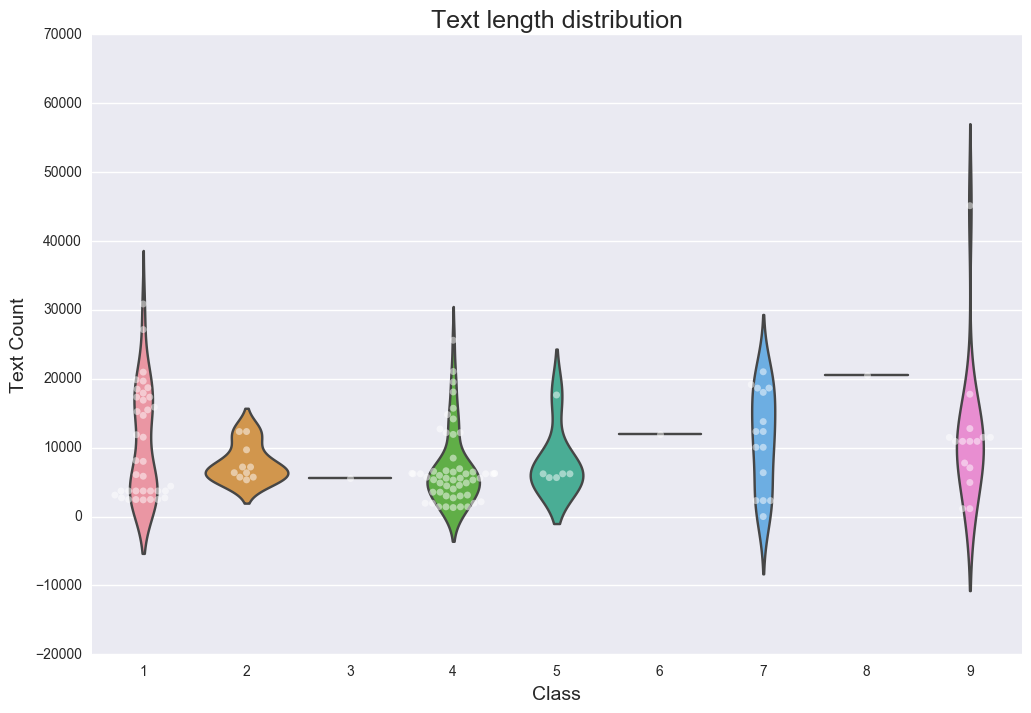

In [8]:
plt.figure(figsize=(12,8))
gene_count_grp = df.groupby('Gene')["Text_count"].sum().reset_index()
sns.violinplot(x="Class", y="Text_count", data=df, inner=None)
sns.swarmplot(x="Class", y="Text_count", data=df, color="w", alpha=.5);
plt.ylabel('Text Count', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Text length distribution", fontsize=18)
plt.show()

Distribution looks quite interesting and now I am in love with violin plots. All classes have most counts in between 0 to 20000. Just as expected. There should be some

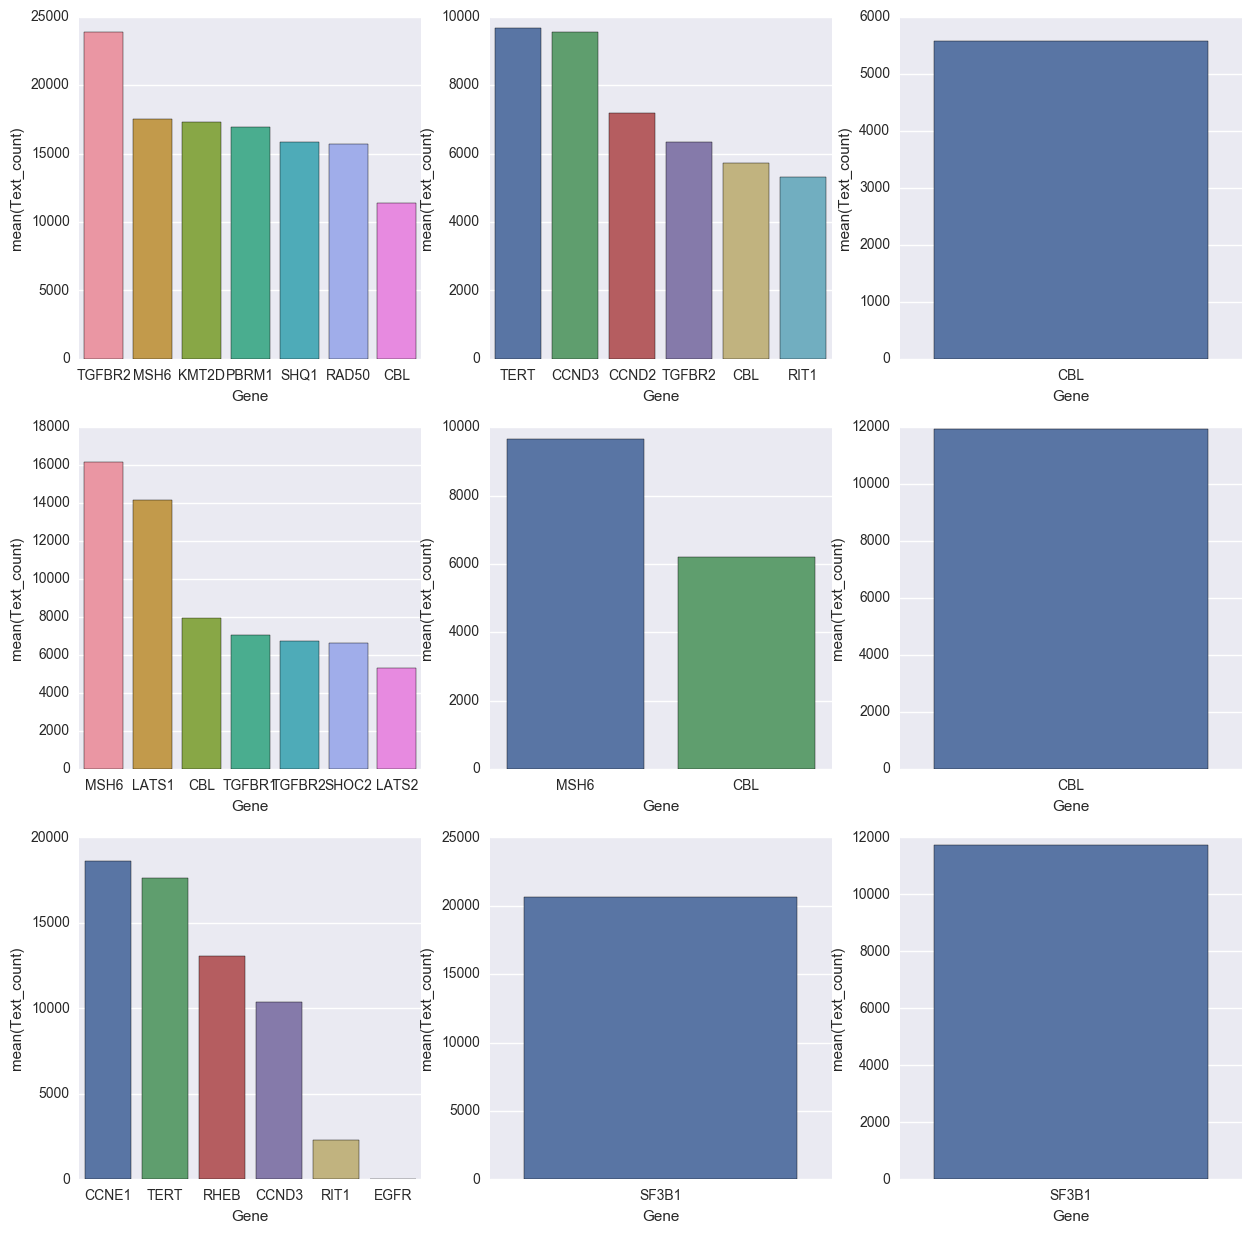

In [9]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = df[df["Class"]==((i*3+j)+1)].groupby('Gene')["Text_count"].mean().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('Text_count', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="Text_count", data=sorted_gene_group_top_7, ax=axs[i][j])

Frequently occurring terms for each class

In [10]:
df['Variation'].describe()

count                      139
unique                     120
top       Truncating Mutations
freq                         9
Name: Variation, dtype: object

*Gene* column is a bit more complicated, values seems to be heavly skewed.  
Data can still be valuable if normalized and balanced by weights.  

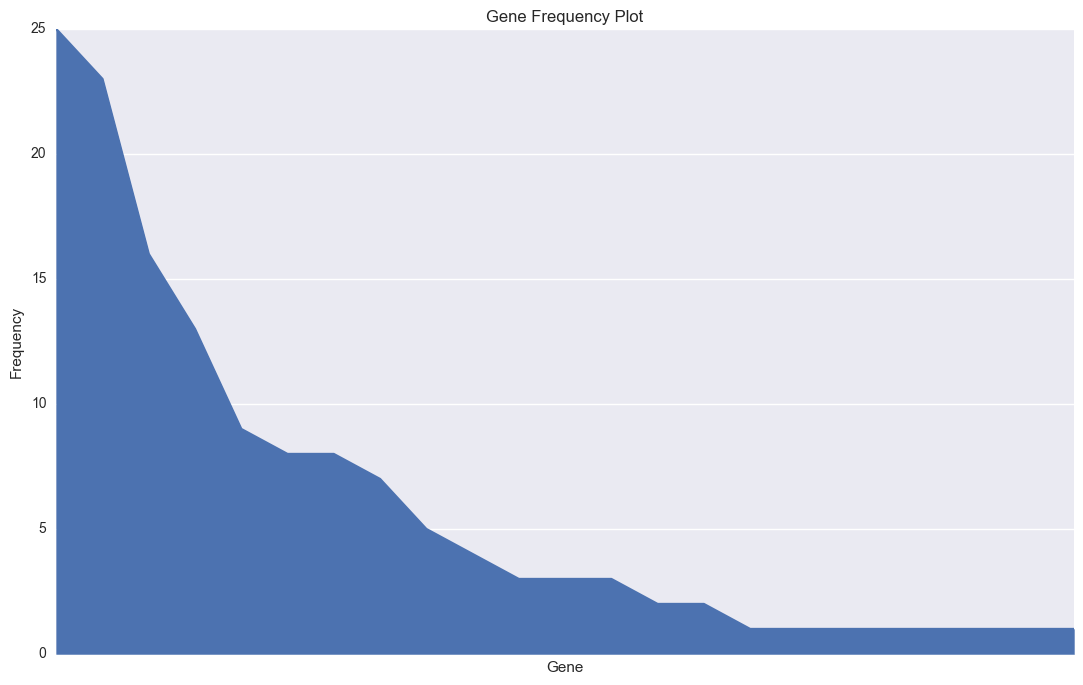

In [11]:
plt.figure()
ax = df['Gene'].value_counts().plot(kind='area')

ax.get_xaxis().set_ticks([])
ax.set_title('Gene Frequency Plot')
ax.set_xlabel('Gene')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

And finally lets look at the class distribution.

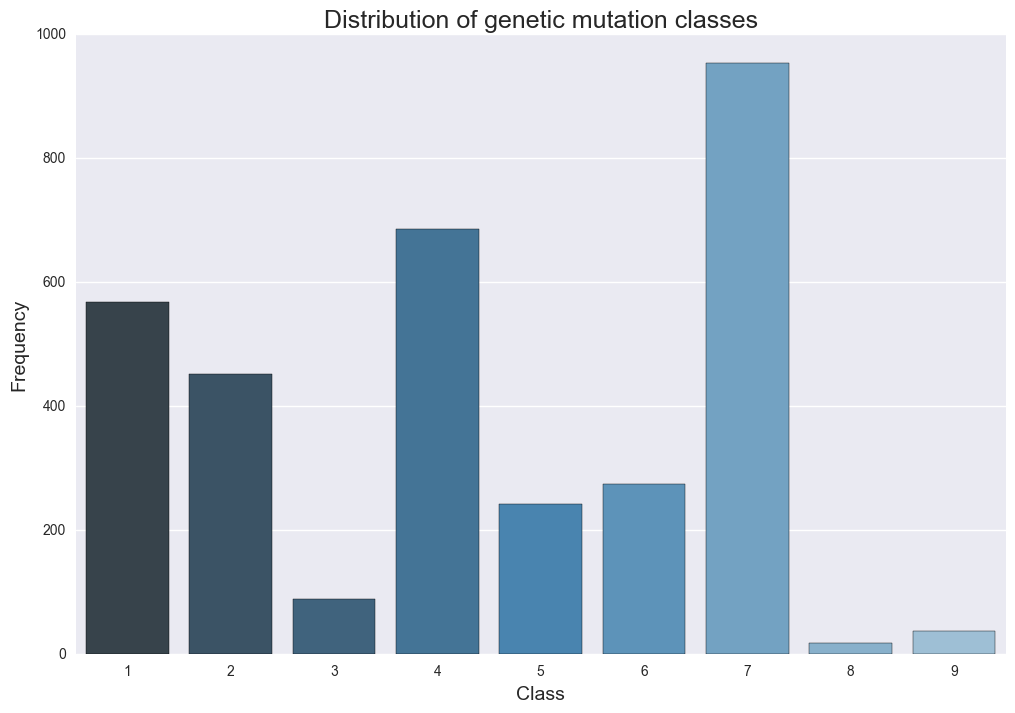

In [17]:
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=df_variants, palette="Blues_d")
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Distribution of genetic mutation classes", fontsize=18)
plt.show()

Distribution looks skewed towards some classes, there are not enough examples for classes 8 and 9. During training, this can be solved using bias weights, careful sampling in batches or simply removing some of the dominant data to equalize the field.  
  
  ----
Finally, lets drop the columns we don't need and be done with the initial cleaning.

In [18]:
gene_group = df_variants.groupby("Gene")['Gene'].count()
minimal_occ_genes = gene_group.sort_values(ascending=True)[:10]
print("Genes with maximal occurences\n", gene_group.sort_values(ascending=False)[:10])
print("\nGenes with minimal occurences\n", minimal_occ_genes)

Genes with maximal occurences
 Gene
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
Name: Gene, dtype: int64

Genes with minimal occurences
 Gene
KLF4      1
FGF19     1
FANCC     1
FAM58A    1
PAK1      1
ERRFI1    1
PAX8      1
PIK3R3    1
PMS1      1
PPM1D     1
Name: Gene, dtype: int64


Lets have a look at some genes that has highest number of occurrences in each class.

In [19]:
df_variants=df_variants.reset_index()

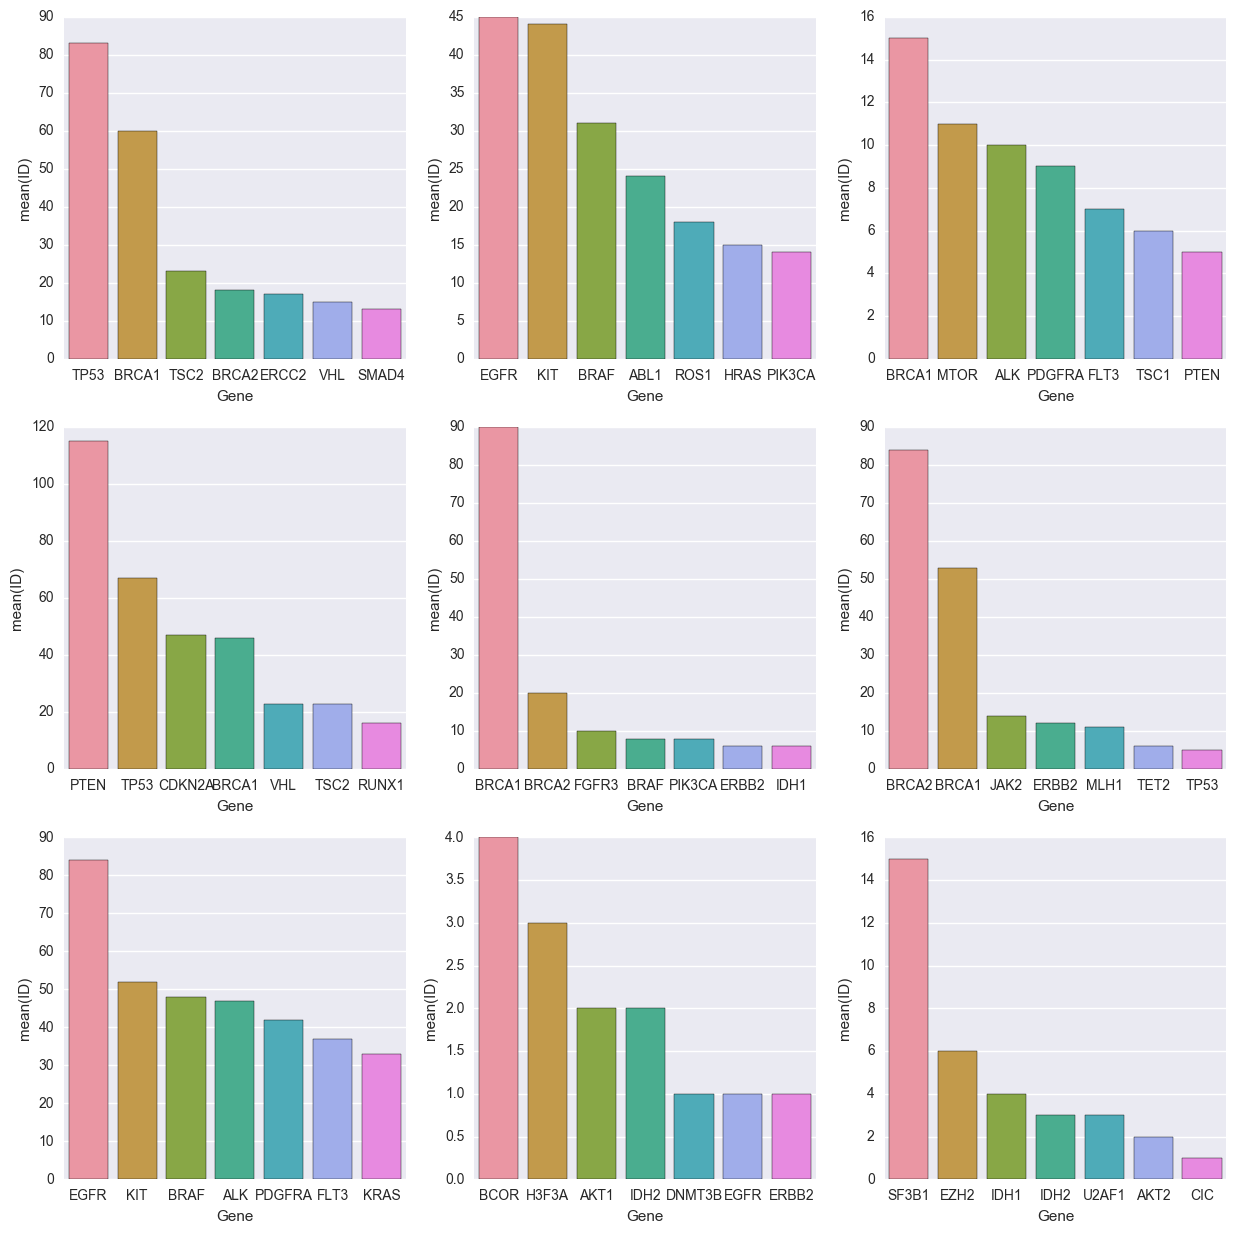

In [20]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = df_variants[df_variants["Class"]==((i*3+j)+1)].groupby('Gene')["ID"].count().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('ID', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="ID", data=sorted_gene_group_top_7, ax=axs[i][j])


Some points we can conclude from these graphs:
BRCA1 is highly dominating Class 5
SF3B1 is highly dominating Class 9
BRCA1 and BRCA2 are dominating Class 6

In [21]:
df.drop(['Gene', 'Variation'], axis=1, inplace=True)

# Additionaly we will drop the null labeled texts too
df = df[df['Text'] != 'null']

Now let's look at the remaining data in more detail.  
Text is too long and detailed and technical, so I've decided to summarize it using gensim's TextRank algorithm.  
Still didn't understand anything :/

In [22]:
t_id = 0
text = df.loc[t_id, 'Text']

word_scores = keywords(text, words=5, scores=True, split=True, lemmatize=True)
word_scores = ', '.join(['{}-{:.2f}'.format(k, s[0]) for k, s in word_scores])
summary = summarize(text, word_count=100)

print('ID [{}]\nKeywords: [{}]\nSummary: [{}]'.format(t_id, word_scores, summary))

ID [0]
Keywords: [cdk-0.39, cell-0.22, ets-0.21, proteins-0.21, gene-0.17]
Summary: [Finally, we detect an increased ETS2 expression level in cells derived from a STAR patient, and we demonstrate that it is attributable to the decreased cyclin M expression level observed in these cells.Previous SectionNext SectionResultsA yeast two-hybrid (Y2H) screen unveiled an interaction signal between CDK10 and a mouse protein whose C-terminal half presents a strong sequence homology with the human FAM58A gene product [whose proposed name is cyclin M (11)].
Altogether, these results suggest that CDK10/cyclin M directly controls ETS2 degradation through the phosphorylation of these two serines.Finally, we studied a lymphoblastoid cell line derived from a patient with STAR syndrome, bearing FAM58A mutation c.555+1G>A, predicted to result in aberrant splicing (10).]


Text is tokenized, cleaned of stopwords and lemmatized for word frequency analysis.  

Tokenization obviously takes a lot of time on a corpus like this. So bear that in mind.  
May skip this, use a simpler tokenizer like `ToktokTokenizer` or just use `str.split()` instead.

In [23]:
custom_words = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show", '"', "’", "“", "”"]

stop_words = set(stopwords.words('english') + list(punctuation) + custom_words)
wordnet_lemmatizer = WordNetLemmatizer()

class_corpus = df.groupby('Class').apply(lambda x: x['Text'].str.cat())
class_corpus = class_corpus.apply(lambda x: Counter(
    [wordnet_lemmatizer.lemmatize(w) 
     for w in word_tokenize(x) 
     if w.lower() not in stop_words and not w.isdigit()]
))

Lets look at the dominant words in classes. And see if we can find any correlation.

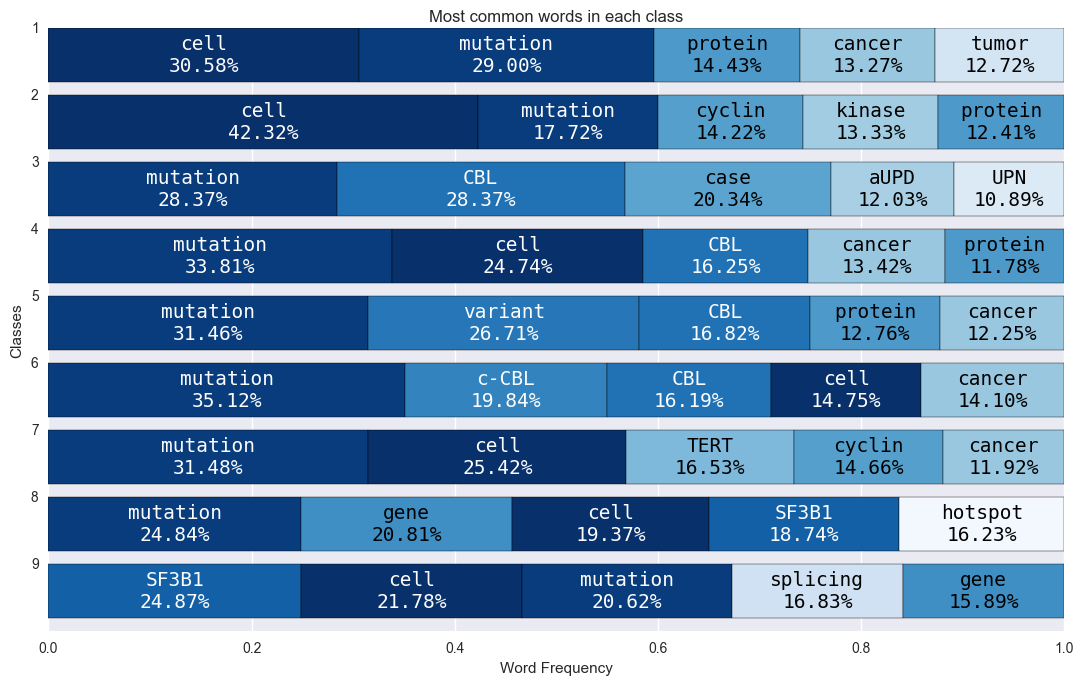

In [24]:
class_freq = class_corpus.apply(lambda x: x.most_common(5))
class_freq = pd.DataFrame.from_records(class_freq.values.tolist()).set_index(class_freq.index)

def normalize_row(x):
    label, repetition = zip(*x)
    t = sum(repetition)
    r = [n/t for n in repetition]
    return list(zip(label,r))

class_freq = class_freq.apply(lambda x: normalize_row(x), axis=1)

# set unique colors for each word so it's easier to read
all_labels = [x for x in class_freq.sum().sum() if isinstance(x,str)]
unique_labels = set(all_labels)
cm = plt.get_cmap('Blues_r', len(all_labels))
colors = {k:cm(all_labels.index(k)/len(all_labels)) for k in all_labels}

fig, ax = plt.subplots()

offset = np.zeros(9)
for r in class_freq.iteritems():
    label, repetition = zip(*r[1])
    ax.barh(range(len(class_freq)), repetition, left=offset, color=[colors[l] for l in label])
    offset += repetition
    
ax.set_yticks(np.arange(len(class_freq)))
ax.set_yticklabels(class_freq.index)
ax.invert_yaxis()

# annotate words
offset_x = np.zeros(9) 
for idx, a in enumerate(ax.patches):
    fc = 'k' if sum(a.get_fc()) > 2.5 else 'w'
    ax.text(offset_x[idx%9] + a.get_width()/2, a.get_y() + a.get_height()/2, 
            '{}\n{:.2%}'.format(all_labels[idx], a.get_width()), 
            ha='center', va='center', color=fc, fontsize=14, family='monospace')
    offset_x[idx%9] += a.get_width()
    
ax.set_title('Most common words in each class')
ax.set_xlabel('Word Frequency')
ax.set_ylabel('Classes')

plt.tight_layout()
plt.show()

**Mutation** and **cell** seems to be commonly dominating in all classes, not very informative. But the graph is still helpful. And would give more insight if we were to ignore most common words.  
Let's plot how many times 25 most common words appear in the whole corpus.

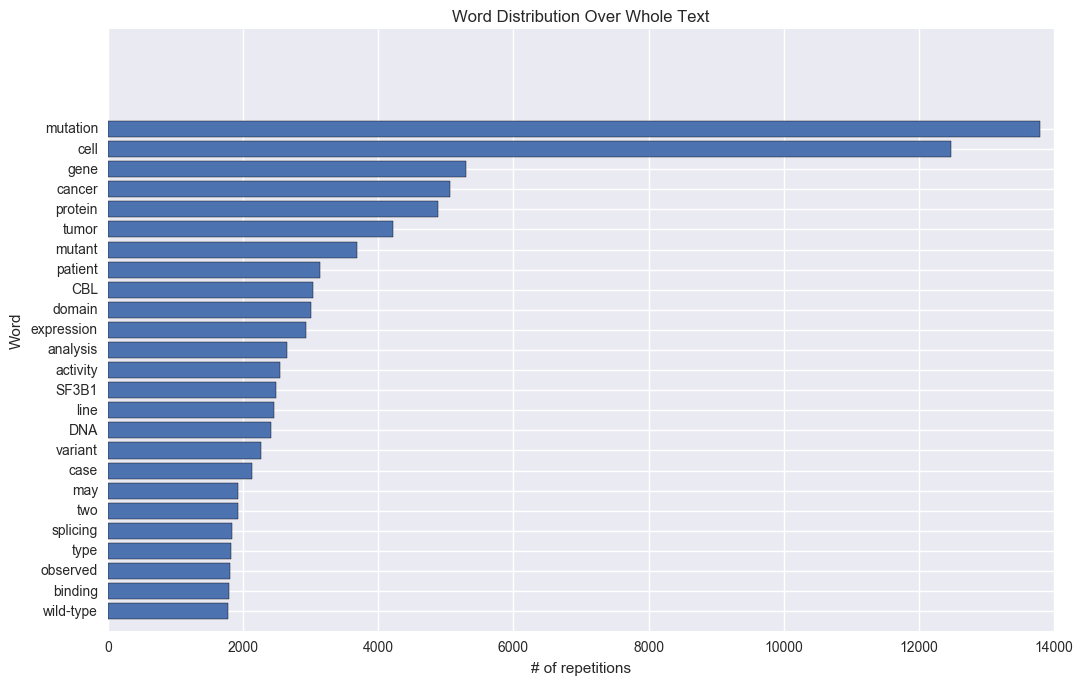

In [25]:
whole_text_freq = class_corpus.sum()

fig, ax = plt.subplots()

label, repetition = zip(*whole_text_freq.most_common(25))

ax.barh(range(len(label)), repetition, align='center')
ax.set_yticks(np.arange(len(label)))
ax.set_yticklabels(label)
ax.invert_yaxis()

ax.set_title('Word Distribution Over Whole Text')
ax.set_xlabel('# of repetitions')
ax.set_ylabel('Word')

plt.tight_layout()
plt.show()

Words are plotted to a word cloud using the beautiful [word_cloud](https://github.com/amueller/word_cloud) library.  
This part is unnecessary for analysis but pretty =).


```python
def resize_image(np_img, new_size):
    old_size = np_img.shape
    ratio = min(new_size[0]/old_size[0], new_size[1]/old_size[1])
    
    return imresize(np_img, (round(old_size[0]*ratio), round(old_size[1]*ratio)))

mask_image = np.array(Image.open('tmp/dna_stencil.png').convert('L'))
mask_image = resize_image(mask_image, (4000, 2000))

wc = WordCloud(max_font_size=140,
               min_font_size=8,
               max_words=1000,
               width=mask_image.shape[1], 
               height=mask_image.shape[0],
               prefer_horizontal=.9,
               relative_scaling=.52,
               background_color=None,
               mask=mask_image,
               mode="RGBA").generate_from_frequencies(freq)

plt.figure()
plt.axis("off")
plt.tight_layout()
plt.imshow(wc, interpolation="bilinear")
```

![](http://i.imgur.com/oRQptjx.png?1)
  
We can also use the text data and visualize the relationships between words using Word2Vec. Even average the word vectors of a sentence and visualize the relationship between sentences.  
(Doc2Vec could give much better results, for simplicity averaging word vectors are sufficient for this kernel)  
  
We'll use gensim's word2vec algorithm with Google's (huge) pretrained word2vec tokens.

```python
vector_path = r"word_vectors\GoogleNews-vectors-negative300.bin"

model = KeyedVectors.load_word2vec_format (vector_path, binary=True)
model.wv.similar_by_word('mutation')
```

```
[('mutations', 0.8541924953460693),  
 ('genetic_mutation', 0.8245046138763428),  
 ('mutated_gene', 0.7879971861839294),  
 ('gene_mutation', 0.7823827266693115),  
 ('genetic_mutations', 0.7393667697906494),  
 ('gene', 0.7343351244926453),  
 ('gene_mutations', 0.7275242209434509),  
 ('genetic_variant', 0.7182294726371765),  
 ('alleles', 0.7164379358291626),  
 ('mutant_gene', 0.7144376039505005)] 
 ```

The results of word2vec looks really promising.  
  
----
Now that we can somewhat understand the relationship between words, we'll use that to understand the relationship between sentences and documents. I'll be simply averaging the word vectors over a sentence, but better ways exist like using idf weighted averages or training a paragraph2vec model from scratch over the corpus.

```python
def get_average_vector(text):
    tokens = [w.lower() for w in word_tokenize(text) if w.lower() not in stop_words]
    return np.mean(np.array([model.wv[w] for w in tokens if w in model]), axis=0)

model.wv.similar_by_vector(get_average_vector(df.loc[0, 'Text']))
```

```
[('cyclic_AMP_cAMP', 0.7930851578712463),
 ('mRNA_transcripts', 0.7838510274887085),
 ('oncogenic_transformation', 0.7836254239082336),
 ('MT1_MMP', 0.7755827307701111),
 ('microRNA_molecule', 0.773587703704834),
 ('tumorigenicity', 0.7722263932228088),
 ('coexpression', 0.7706621885299683),
 ('transgenic_mice_expressing', 0.7698256969451904),
 ('pleiotropic', 0.7698150873184204),
 ('cyclin_B1', 0.7696200013160706)]
```
  
And finally we can visualize the relationships between sentences by averaging the vector representations of each word in a sentence and reducing the vector dimensions to 2D (Google's Word2Vec embeddings come as [,300] vectors).  
I will use PCA for dimensionality reduction because it usually is faster (and/or uses less memory) but t-sne could give better results.

```python
text_vecs = df.apply(lambda x: (x['Class'], get_average_vector(x['Text'])), axis=1)
classes, vecs = list(zip(*text_vecs.values))

pca = PCA(n_components=2)
reduced_vecs = pca.fit_transform(vecs)

fig, ax = plt.subplots()

cm = plt.get_cmap('jet', 9)
colors = [cm(i/9) for i in range(9)]
ax.scatter(reduced_vecs[:,0], reduced_vecs[:,1], c=[colors[c-1] for c in classes], cmap='jet', s=8)


plt.legend(handles=[Patch(color=colors[i], label='Class {}'.format(i+1)) for i in range(9)])

plt.show()
```

![](http://i.imgur.com/hT6GIAK.png)
  
No imminent correlation can be seen based on this analysis.  
This may be due to:
- Dimensional Reduction (we may not be seeing the correlation in 2D).
- Averaging word vectors are not effective solutions to infer sentence/paragraph vectors.
- There is no obvious correlation between texts.
  
In any case let's see the difference with a simple k-means clustering.

```python
kmeans = KMeans(n_clusters=9).fit(vecs)
c_labels = kmeans.labels_

fig, ax = plt.subplots()

cm = plt.get_cmap('jet', 9)
colors = [cm(i/9) for i in range(9)]
ax.scatter(reduced_vecs[:,0], reduced_vecs[:,1], c=[colors[c-1] for c in c_labels], cmap='jet', s=8)

plt.legend(handles=[Patch(color=colors[i], label='Class {}'.format(i+1)) for i in range(9)])

plt.show()
```

![](http://i.imgur.com/IYjRzd0.png)